In [1]:
import phantom_gpu
import matplotlib.pyplot as plt
import torch
import numpy as np
import napari
from R2_3d_gpu import compute_R2_3d_gpu
from R1_3d_gpu import compute_R1_3d_gpu
from simAcquireAllKSlines_gpu import simAcquireAllKSlines_gpu

simulating the phantom based on prior average data

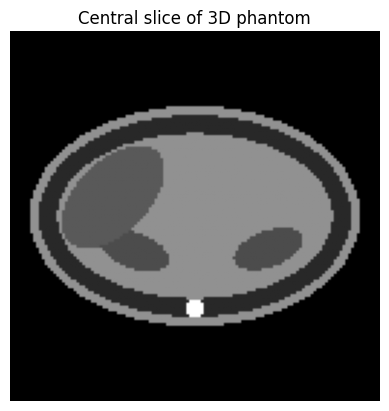

In [2]:
phantom_vol = phantom_gpu.phantom3d_gpu(n=128)
plt.imshow(phantom_vol[64].cpu(), cmap='gray')
plt.title("Central slice of 3D phantom")
plt.axis('off')
plt.show()
# anime = napari.view_image(phantom_vol, name='3D Phantom', colormap='gray')

Creating the model parameters

In [3]:
R1_3d = compute_R1_3d_gpu(); R1_3d.shape
# napari.view_image(R1_3d[...,0], name='R1_3d', colormap='gray')

torch.Size([128, 128, 128, 3])

In [4]:
R2_3d = compute_R2_3d_gpu(); R2_3d.shape
# napari.view_image(R2_3d[...,0], name='R2_3d', colormap='gray')

torch.Size([128, 128, 128, 3])

In [5]:
device = torch.device('cuda')


R1_3d = 2 * (R1_3d - R1_3d.min()) / (R1_3d.max() - R1_3d.min()) - 1
R2_3d = 2 * (R2_3d - R2_3d.min()) / (R2_3d.max() - R2_3d.min()) - 1

R1_mag = torch.tensor([5, 5, 5])
R2_mag = torch.tensor([5, 5, 5])



R1_true = torch.zeros_like(R1_3d, device=device)
R2_true = torch.zeros_like(R2_3d, device=device)

R1_true[...,0] = R1_mag[0] * R1_3d[...,0]
R1_true[...,1] = R1_mag[1] * R1_3d[...,1]
R1_true[...,2] = R1_mag[2] * R1_3d[...,2]

R2_true[...,0] = R2_mag[0] * R2_3d[...,0]
R2_true[...,1] = R2_mag[1] * R2_3d[...,1]
R2_true[...,2] = R2_mag[2] * R2_3d[...,2]

importing the surrogate signals

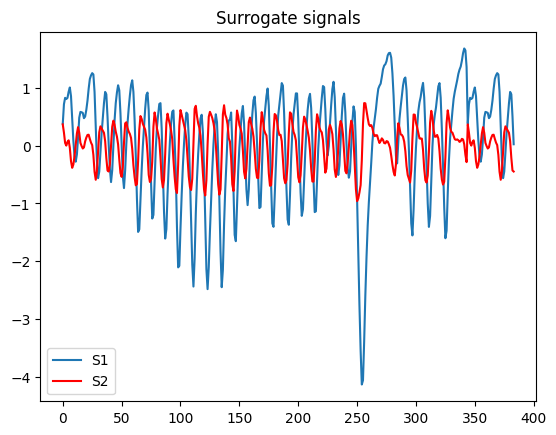

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = np.loadtxt('proj_CV_delCV.txt')
S1 = torch.tensor(-data[:,1], device=device)
S2 = torch.tensor(-data[:,2], device=device)

# Define sequence of k-space lines (here full coverage repeated 3 times)
KS_lines = list(range(128))
KS_lines = KS_lines + KS_lines + KS_lines
# Ensure surrogate arrays match number of lines
S1_acq = S1.clone(); S2_acq = S2.clone()
while len(S1_acq) < len(KS_lines):
    S1_acq = torch.concat([S1_acq, S1_acq])
    S2_acq = torch.concat([S2_acq, S2_acq])
S1_acq = S1_acq[:len(KS_lines)]
S2_acq = S2_acq[:len(KS_lines)]

# Plot surrogate signals
plt.figure()
plt.plot(S1_acq.cpu(), label='S1')
plt.plot(S2_acq.cpu(), label='S2', color='red')
plt.title('Surrogate signals')
plt.legend()
plt.show()

simulating the k-space

In [7]:
run_sim = False
if run_sim:
    KS_acq, anim_mov_acq = simAcquireAllKSlines_gpu(phantom_vol, R1_3d, R2_3d, S1_acq, S2_acq, KS_lines, noise=0.05, anim=True, save=True)
    torch.save(KS_acq, "KS_acq.pt")
else:
    KS_acq = torch.load("KS_acq.pt").to(device)

In [8]:
# import numpy as np
# np.save("KS_acq.npy", KS_acq)


In [9]:
from save_anim_gpu import save_animation_gpu


save_anim = False
if save_anim:
    # Assuming anim_mov_acq is a numpy array of shape (T, H, W)
    save_animation_gpu(anim_mov_acq, output_path='m/my_animation.mp4', fps=15)


In [10]:
# from IPython.display import Video, display
# display(Video("anim.mp4", embed=True, width=1000, height=1000))


fitting

In [11]:
lims_R1_x = (float(torch.min(R1_true[..., 2]).to(device)), float(torch.max(R1_true[..., 2]).to(device)))
lims_R1_y = (float(torch.min(R1_true[..., 1]).to(device)), float(torch.max(R1_true[..., 1]).to(device)))
lims_R1_z = (float(torch.min(R1_true[..., 0]).to(device)), float(torch.max(R1_true[..., 0]).to(device)))

lims_R2_x = (float(torch.min(R2_true[..., 2]).to(device)), float(torch.max(R2_true[..., 2]).to(device)))
lims_R2_y = (float(torch.min(R2_true[..., 1]).to(device)), float(torch.max(R2_true[..., 1]).to(device)))
lims_R2_z = (float(torch.min(R2_true[..., 0]).to(device)), float(torch.max(R2_true[..., 0]).to(device)))

In [12]:
lims_R1_x, lims_R1_y, lims_R1_z, lims_R2_x, lims_R2_y, lims_R2_z

((-2.407407283782959, 5.0),
 (-5.0, 2.407407283782959),
 (-2.407407283782959, 5.0),
 (-3.5714287757873535, 0.7142853736877441),
 (-5.0, -3.5714287757873535),
 (-3.5714287757873535, 5.0))

In [ ]:
from fitModelAndNonIterMCRToKSlines_gpu import fitModelAndNonIterMCRToKSlines_gpu


I_rec, R1_fit, R2_fit, anim_mov_fit, loss = fitModelAndNonIterMCRToKSlines_gpu(KS_acq, S1_acq, S2_acq, KS_lines,
                                                                    anim=True, sigma=5,
                                                                    lims_R1_x=lims_R1_x, lims_R1_y=lims_R1_y, lims_R1_z=lims_R1_z,
                                                                    lims_R2_x=lims_R2_x, lims_R2_y=lims_R2_y, lims_R2_z=lims_R2_z,
                                                                    I_size=phantom_vol.shape, C_thresh=0.001)


=== Level 1 ===============================


100%|██████████| 384/384 [00:33<00:00, 11.57it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim.mp4
[Level 1] initial loss C = 2.101016e+19

[Level 1] Iteration 0
  -> current loss C = 2.101016e+19
   Testing step size 1.0


100%|██████████| 384/384 [00:35<00:00, 10.81it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim_1.0.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.5


100%|██████████| 384/384 [00:38<00:00,  9.87it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim_0.5.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.25


100%|██████████| 384/384 [00:39<00:00,  9.81it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim_0.25.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.125


100%|██████████| 384/384 [00:38<00:00,  9.85it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim_0.125.mp4
     -> improved! new loss = 2.101016e+19


100%|██████████| 384/384 [00:39<00:00,  9.81it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim_0.125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 2.199023e+12
   Testing step size 0.0625


100%|██████████| 384/384 [00:39<00:00,  9.84it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim_0.0625.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 2.199023e+12
   Testing step size 0.03125


100%|██████████| 384/384 [00:39<00:00,  9.75it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim_0.03125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 2.199023e+12
   Testing step size 0.015625


100%|██████████| 384/384 [00:38<00:00,  9.93it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim_0.015625.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 2.199023e+12
   Testing step size 0.0078125


100%|██████████| 384/384 [00:38<00:00,  9.94it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim_0.0078125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 2.199023e+12
  Reconstructing image with updated motion...


100%|██████████| 384/384 [00:35<00:00, 10.87it/s]


Saved MP4 to I_rec_test_GPU_level_1/anim_updated_I_rec.mp4
  -> post-recon loss = 2.111842e+19
[Level 1] Final loss = 2.111842e+19

=== Level 2 ===============================


100%|██████████| 384/384 [00:38<00:00,  9.96it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim.mp4
[Level 2] initial loss C = 2.111842e+19

[Level 2] Iteration 0
  -> current loss C = 2.111842e+19
   Testing step size 1.0


100%|██████████| 384/384 [00:35<00:00, 10.73it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_1.0.mp4
     -> improved! new loss = 2.110880e+19


100%|██████████| 384/384 [00:38<00:00,  9.96it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_1.0.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 9.614130e+15
   Testing step size 0.5


100%|██████████| 384/384 [00:38<00:00,  9.94it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.5.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 9.614130e+15
   Testing step size 0.25


100%|██████████| 384/384 [00:38<00:00,  9.97it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.25.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 9.614130e+15
   Testing step size 0.125


100%|██████████| 384/384 [00:38<00:00, 10.00it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 9.614130e+15
   Testing step size 0.0625


100%|██████████| 384/384 [00:38<00:00,  9.94it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.0625.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 9.614130e+15
   Testing step size 0.03125


100%|██████████| 384/384 [00:38<00:00,  9.96it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.03125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 9.614130e+15
   Testing step size 0.015625


100%|██████████| 384/384 [00:38<00:00,  9.94it/s]
e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation_GPU\save_anim_gpu.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation_GPU\simAcquireAllKSlines_gpu.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 2, figsize=(8, 8))


Saved MP4 to I_rec_test_GPU_level_2/anim_0.015625.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 9.614130e+15
   Testing step size 0.0078125


100%|██████████| 384/384 [00:38<00:00,  9.88it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.0078125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 9.614130e+15
  Reconstructing image with updated motion...


100%|██████████| 384/384 [00:34<00:00, 11.10it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_updated_I_rec.mp4
  -> post-recon loss = 2.056470e+19

[Level 2] Iteration 1
  -> current loss C = 2.056470e+19
   Testing step size 1.0


100%|██████████| 384/384 [00:35<00:00, 10.79it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_1.0.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.5


100%|██████████| 384/384 [00:38<00:00, 10.02it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.5.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.25


100%|██████████| 384/384 [00:38<00:00,  9.92it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.25.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.125


100%|██████████| 384/384 [00:38<00:00, 10.05it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.0625


100%|██████████| 384/384 [00:38<00:00,  9.94it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.0625.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.03125


100%|██████████| 384/384 [00:38<00:00, 10.00it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.03125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.015625


100%|██████████| 384/384 [00:38<00:00, 10.04it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.015625.mp4
     -> improved! new loss = 2.056429e+19


100%|██████████| 384/384 [00:38<00:00,  9.92it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.015625.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 4.068193e+14
   Testing step size 0.0078125


100%|██████████| 384/384 [00:38<00:00, 10.02it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_0.0078125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 4.068193e+14
  Reconstructing image with updated motion...


100%|██████████| 384/384 [00:33<00:00, 11.42it/s]


Saved MP4 to I_rec_test_GPU_level_2/anim_updated_I_rec.mp4
  -> post-recon loss = 2.056107e+19
[Level 2] Final loss = 2.056107e+19

=== Level 3 ===============================


100%|██████████| 384/384 [00:38<00:00,  9.93it/s]


Saved MP4 to I_rec_test_GPU_level_3/anim.mp4
[Level 3] initial loss C = 2.056107e+19

[Level 3] Iteration 0
  -> current loss C = 2.056107e+19
   Testing step size 1.0


100%|██████████| 384/384 [00:35<00:00, 10.86it/s]


Saved MP4 to I_rec_test_GPU_level_3/anim_1.0.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.5


100%|██████████| 384/384 [00:38<00:00,  9.98it/s]


Saved MP4 to I_rec_test_GPU_level_3/anim_0.5.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 0.000000e+00
   Testing step size 0.25


100%|██████████| 384/384 [00:38<00:00, 10.01it/s]


Saved MP4 to I_rec_test_GPU_level_3/anim_0.25.mp4
     -> improved! new loss = 2.055470e+19


100%|██████████| 384/384 [00:38<00:00,  9.86it/s]


Saved MP4 to I_rec_test_GPU_level_3/anim_0.25.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 6.370570e+15
   Testing step size 0.125


100%|██████████| 384/384 [00:38<00:00,  9.99it/s]


Saved MP4 to I_rec_test_GPU_level_3/anim_0.125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 6.370570e+15
   Testing step size 0.0625


100%|██████████| 384/384 [00:38<00:00, 10.01it/s]


Saved MP4 to I_rec_test_GPU_level_3/anim_0.0625.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 6.370570e+15
   Testing step size 0.03125


100%|██████████| 384/384 [00:38<00:00,  9.98it/s]


Saved MP4 to I_rec_test_GPU_level_3/anim_0.03125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 6.370570e+15
   Testing step size 0.015625


100%|██████████| 384/384 [00:38<00:00,  9.99it/s]


Saved MP4 to I_rec_test_GPU_level_3/anim_0.015625.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 6.370570e+15
   Testing step size 0.0078125


100%|██████████| 384/384 [00:38<00:00,  9.95it/s]


Saved MP4 to I_rec_test_GPU_level_3/anim_0.0078125.mp4
No improvement in this iteration
   Improvement below threshold: ΔC = 6.370570e+15
  Reconstructing image with updated motion...


 70%|███████   | 269/384 [00:30<00:12,  9.52it/s]

In [ ]:
I_rec_mag = np.abs(I_rec)
import SimpleITK as sitk
I_rec_mag_img = sitk.GetImageFromArray(I_rec_mag)
sitk.WriteImage(I_rec_mag_img, "I_rec_test1.nii.gz")

In [ ]:
import SimpleITK as sitk
R1_fit_img = sitk.GetImageFromArray(R1_fit)
sitk.WriteImage(R1_fit_img, "R1_fit_test1.nii.gz")

In [ ]:
import SimpleITK as sitk
R2_fit_img = sitk.GetImageFromArray(R2_fit)
sitk.WriteImage(R2_fit_img, "R2_fit_test1.nii.gz")

In [ ]:
len(anim_mov_fit)

3

In [ ]:
plt.imsave("fig3.png", anim_mov_fit[2])

In [ ]:
from save_anim import save_animation

save_animation(anim_mov_fit, output_path='frame_test/my_animation.mp4', fps=10)

Saved MP4 to frame_test/my_animation.mp4


In [ ]:
napari.view_image(np.abs(I_rec), name='Reconstructed', colormap='gray')

Viewer(camera=Camera(center=(0.0, np.float64(63.5), np.float64(63.5)), zoom=np.float64(4.453125), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(63.0), 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(63.0), np.float64(63.0), np.float64(63.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), laye

In [ ]:
napari.view_image(R2_fit[...,0], name='R2_fit', colormap='gray')

Viewer(camera=Camera(center=(0.0, np.float64(63.5), np.float64(63.5)), zoom=np.float64(4.453125), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(63.0), 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(63.0), np.float64(63.0), np.float64(63.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), laye

In [ ]:
np.save("I_rec.npy", I_rec)

In [ ]:
napari.view_image(np.abs(I_rec)-phantom_vol, name='Difference', colormap='viridis')

Viewer(camera=Camera(center=(0.0, np.float64(63.5), np.float64(63.5)), zoom=np.float64(4.453125), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(63.0), 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(63.0), np.float64(63.0), np.float64(63.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), laye

In [ ]:
# import napari
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
# from qtpy.QtWidgets import QFrame, QVBoxLayout

# # your data
# diff = np.abs(I_rec) - phantom_vol

# # 1) create the viewer and add your image
# viewer = napari.Viewer()
# layer = viewer.add_image(diff, name='Difference', colormap='viridis')

# # 2) make a tiny Matplotlib Figure for the colorbar
# fig = plt.figure(figsize=(1, 4))
# ax = fig.add_axes([0.05, 0.05, 0.3, 0.9])

# # make the ScalarMappable with the same colormap & contrast limits
# norm = plt.Normalize(vmin=layer.contrast_limits[0],
#                      vmax=layer.contrast_limits[1])
# sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
# sm.set_array([])

# # draw the colorbar into that ax
# fig.colorbar(sm, cax=ax)

# # 3) put the Figure onto a Qt widget and dock it
# canvas = FigureCanvasQTAgg(fig)
# container = QFrame()
# container.setLayout(QVBoxLayout())
# container.layout().addWidget(canvas)
# viewer.window.add_dock_widget(container, name='Colorbar', area='right')

# napari.run()


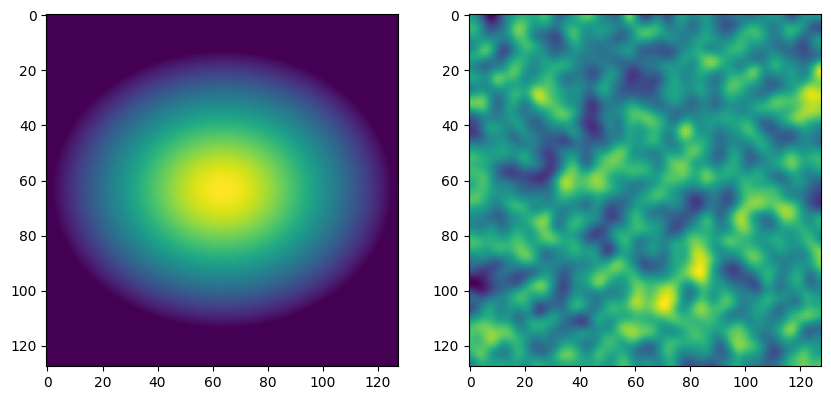

In [ ]:
# ...existing code...
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(R2_3d[64, ..., 2])
ax[1].imshow(R2_fit[64, ..., 2])
# ...existing code...